# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Processamento de Linguagem Natural</font>

## Mini-Projeto - Classificação de Documentos com Word2Vec

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


Embora o Word2vec ofereça uma maneira muito elegante de aprender representações numéricas de palavras, quantitativamente (valor de perda) e qualitativamente (t-SNE embeddings), aprender representações de palavra por si só não é convincente o suficiente para perceber o poder dos vetores de palavras em aplicações do mundo real. 

Word embeddings são usados como a representação de recursos de palavras para muitas tarefas, como geração de legenda de imagem e tradução automática. No entanto, essas tarefas envolvem a combinação de diferentes modelos de aprendizado (como modelos de Redes Neurais Convolucionais (CNNs) e Long Short-Term Memory (LSTM) modelos que estudaremos na sequência do curso). Para entender o uso real das Word embeddings, vamos nos ater a uma tarefa mais simples - a classificação de documentos.

A classificação de documentos é uma das tarefas mais populares em PLN. A classificação de documentos é extremamente útil para qualquer pessoa que esteja lidando com coleções massivas de dados, como as de sites de notícias, editores, advogados e universidades. Portanto, é interessante ver como a aprendizagem dos vetores de palavras pode ser adaptada a uma tarefa do mundo real, como a classificação de documentos por meio da embeddings de documentos inteiros em vez de palavras.

## Dataset

Para essa tarefa, usaremos um conjunto de arquivos de texto já organizado. Estes são artigos de notícias da BBC. Todos os documentos desta coleção pertencem a uma das seguintes categorias: 

- Negócios
- Entretenimento
- Política
- Esportes
- Tecnologia

Um exemplo de documento da categoria Tecnologia:

'UK net users leading TV downloads British TV viewers lead the trend of illegally downloading US shows from the net, according to research. New episodes of 24, Desperate Housewives and Six Feet Under, appear on the web hours after they are shown in the US, said a report. Web tracking company Envisional said 18% of downloaders were from within the UK and that downloads of TV programmers had increased by 150% in the last year....'

Nós usamos 250 documentos de cada categoria. Nosso vocabulário será de tamanho 25.000. Além disso, cada documento será representado por uma tag <tipo de documento> - <id> para fins de visualização. Por exemplo, o 50º documento da seção Entretenimento será representado como entretenimento-50. Deve-se notar que este é um conjunto de dados muito pequeno comparado ao grande corpora de texto que está sendo analisado em aplicações do mundo real. No entanto, este pequeno exemplo é adequado no momento para ver o poder das Word embeddings.

Usaremos a seguinte estratégia:

1. Extrair os dados de todos os arquivos de texto e aprender as word embeddings.
2. Extrair conjuntos randômicos de documentos dos word embeddings já treinados.
3. Estender os word embeddings aprendidos para fazer o embed dos documentos selecionados (mais especificamente vamos representar um documento pelo seu valor médio de embeddings pertencentes a todas as palavras encontradas no documento).
4. Visualizar as document embeddings encontradas usando a técnica de visualização t-SNE.
5. Finalmente usaremos um algoritmo como K-means para atribuir um label a cada documento.
    

In [2]:
!nvidia-smi

Sat May 16 22:02:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0 Off |                  N/A |
| 23%   37C    P8     9W / 250W |    115MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   32C    P8     9W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [4]:
# Imports
import os
import nltk
import operator
import math
import collections
import random
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import sklearn
from sklearn.cluster import KMeans
from math import ceil
%matplotlib inline

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

tensorflow       2.2.0
matplotlib       3.2.1
sklearn          0.22.2
numpy            1.18.4
matplotlib.pylab 1.18.4
nltk             3.4.5
Data Science Academy


In [6]:
# Obs: Este script está compatível com as versões 1.x e 2.x do TensorFlow.
# Optamos por manter assim, pois alguns recursos avançados usados neste script ainda não foram implementados no TF 2.

# Para executar este script com TF 2, nenhum passo adicional precisa ser feito.
# Para executar com TF 1, remova o prefixo tf.compat.v1 ao longo do scriipt e substitua por tf, e comente as 3 linhas abaixo.
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.disable_eager_execution()

O código abaixo permite o download do [dataset](http://mlg.ucd.ie/datasets/bbc.html).

In [7]:
url = 'http://mlg.ucd.ie/files/datasets/'

def maybe_download(filename, expected_bytes):
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Encontrado e verificado %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Não foi possível verificar o arquivo ' + filename + '. Você pode fazer o donwload via browser?')
  return filename

filename = maybe_download('bbc-fulltext.zip', 2874078)

Encontrado e verificado bbc-fulltext.zip


## Lendo os dados com pré-processamento com NLTK

Leitura dos dados como estão, converte em minúscula e o converte em tokens usando a biblioteca nltk. Temos duas funções `read_data`, que lê `files_to_read_for_topic` de cada categoria e `read_test_data`, que separa 10 documentos dos documentos lidos para fins de teste.

In [8]:
def read_data(filename):
  """
  Extrai artigos até um determinado limite em um arquivo zip como uma lista de palavras
  e pré-processa usando a biblioteca nltk python
  """
  data = []
  files_to_read_for_topic = 250
  topics = ['business','entertainment','politics','sport','tech']
  with zipfile.ZipFile(filename) as z:
    parent_dir = z.namelist()[0]
    for t in topics:
        print('\tConcluída a leitura de dados para o tópico: ', t)
        for fi in range(1,files_to_read_for_topic):
            with z.open(parent_dir + t + '/'+ format(fi,'03d')+'.txt') as f:
                file_string = f.read().decode('latin-1')
                file_string = file_string.lower()
                file_string = nltk.word_tokenize(file_string)
                data.extend(file_string)

    return data

def read_test_data(filename):
  """
  Extrai artigos até um determinado limite em um arquivo zip como uma lista de palavras
  e pré-processa usando a biblioteca nltk python
  """
  test_data = {}
  files_to_read_for_topic = 250
  topics = ['business','entertainment','politics','sport','tech']
  with zipfile.ZipFile(filename) as z:
    parent_dir = z.namelist()[0]
    for t in topics:
        print('\tConcluída a leitura de dados para o tópico: ',t)

        for fi in np.random.randint(1,files_to_read_for_topic,(10)).tolist():
            with z.open(parent_dir + t + '/'+ format(fi,'03d')+'.txt') as f:
                file_string = f.read().decode('latin-1')
                file_string = file_string.lower()
                file_string = nltk.word_tokenize(file_string)

                # Atribui nome aos arquivos
                test_data[t+'-'+str(fi)] = file_string

    return test_data

print('Processando dados de treinamento...\n')
words = read_data(filename)

print('\nProcessando dados de teste...\n')
test_words = read_test_data(filename)

print('\nPalavras de Exemplo (start): ',words[:10])
print('Palavras de Exemplo (end): ',words[-10:])

Processando dados de treinamento...

	Concluída a leitura de dados para o tópico:  business
	Concluída a leitura de dados para o tópico:  entertainment
	Concluída a leitura de dados para o tópico:  politics
	Concluída a leitura de dados para o tópico:  sport
	Concluída a leitura de dados para o tópico:  tech

Processando dados de teste...

	Concluída a leitura de dados para o tópico:  business
	Concluída a leitura de dados para o tópico:  entertainment
	Concluída a leitura de dados para o tópico:  politics
	Concluída a leitura de dados para o tópico:  sport
	Concluída a leitura de dados para o tópico:  tech

Palavras de Exemplo (start):  ['ad', 'sales', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profits', 'at', 'us']
Palavras de Exemplo (end):  ['almost', '200,000', 'people', 'are', 'registered', 'players', 'on', 'project', 'entropia', '.']


In [9]:
# Visualizando o dataset criado
print(test_words)

{'business-240': ['economy', "'strong", "'", 'in', 'election', 'year', 'uk', 'businesses', 'are', 'set', 'to', 'prosper', 'during', 'the', 'next', 'few', 'months', '-', 'but', 'this', 'could', 'trigger', 'more', 'interest', 'rate', 'rises', ',', 'according', 'to', 'a', 'report', '.', 'optimism', 'is', 'at', 'its', 'highest', 'since', '1997', 'and', 'business', 'will', 'reap', 'the', 'benefits', 'of', 'a', 'continuing', 'rise', 'in', 'public', 'spending', ',', 'say', 'researchers', 'at', 'bdo', 'stoy', 'hayward', '.', 'the', 'bank', 'of', 'england', 'is', 'expected', 'to', 'keep', 'rates', 'on', 'hold', 'this', 'week', '-', 'but', 'they', 'could', 'go', 'up', 'later', 'in', 'the', 'year', '.', 'rates', 'are', 'likely', 'to', 'rise', 'after', 'the', 'anticipated', 'general', 'election', 'in', 'may', '.', 'the', 'bdo', 'optimism', 'index', '-', 'a', 'leading', 'indicator', 'of', 'gdp', 'growth', 'two', 'quarters', 'ahead', 'edged', 'up', 'in', 'january', 'to', '102.5', ',', 'from', '102.2

## Construindo os Dicionários
Para entender cada um desses elementos, vamos também assumir o texto "Eu gosto de ir à escola"

* `dictionary`: mapeia uma palavra para um ID (i.e. {Eu:0, gosto:1, de:2, ir:3, à:4, escola:5})
* `reverse_dictionary`: mapeia um ID para uma palavra (i.e. {0:Eu, 1:gosto, 2:de, 3:ir, 4:à, 5:escola}
* `count`: Lista de elementos (palavra, frequência) (i.e. [(Eu,1),(gosto,1),(de,2),(ir,1),(à,1),(escola,1)]
* `data` : Contém a string de texto que lemos, onde palavras são substituídas por IDs de palavras (i.e. [0, 1, 2, 3, 2, 4])

Também introduzimos um token especial adicional chamado `UNK` para indicar que palavras raras são muito raras para serem usadas.

In [10]:
vocabulary_size = 25000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))

  # Dicionário
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)

  data = list()
  unk_count = 0

  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)

  count[0][1] = unk_count

  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  assert len(dictionary) == vocabulary_size

  return data, count, dictionary, reverse_dictionary

def build_dataset_with_existing_dictionary(words, dictionary):
    '''
    Aqui usamos essa função para converter strings de palavras em IDs com um determinado dicionário
    '''
    data = list()
    for word in words:
        if word in dictionary:
          index = dictionary[word]
        else:
          index = 0  # dictionary['UNK']
        data.append(index)
    return data

# Processando dados de treino
data, count, dictionary, reverse_dictionary = build_dataset(words)

# Processando dados de teste
test_data = {}

for k,v in test_words.items():
    print('Construindo o dataset de teste para o documento ', k)
    test_data[k] = build_dataset_with_existing_dictionary(test_words[k],dictionary)

print('\nPalavras mais comuns (+UNK)', count[:5])
print('\nAmostra de dados', data[:10])
print('\nChaves: ', test_data.keys())
print('\nItems: ', test_data.items())

# Removemos para liberar memória no computador. Não precisamos mais desses objetos.
del words
del test_words

Construindo o dataset de teste para o documento  business-240
Construindo o dataset de teste para o documento  business-13
Construindo o dataset de teste para o documento  business-224
Construindo o dataset de teste para o documento  business-155
Construindo o dataset de teste para o documento  business-170
Construindo o dataset de teste para o documento  business-83
Construindo o dataset de teste para o documento  business-28
Construindo o dataset de teste para o documento  business-136
Construindo o dataset de teste para o documento  business-25
Construindo o dataset de teste para o documento  business-144
Construindo o dataset de teste para o documento  entertainment-68
Construindo o dataset de teste para o documento  entertainment-14
Construindo o dataset de teste para o documento  entertainment-248
Construindo o dataset de teste para o documento  entertainment-98
Construindo o dataset de teste para o documento  entertainment-116
Construindo o dataset de teste para o documento  ent

## Gerando Lotes de Dados para o Skip-Gram

Gera um lote para as palavras de destino (`batch`) e um lote de palavras de contexto correspondentes (`labels`). Ele lê as palavras `2 * window_size + 1` por vez (chamado `span`) e cria os datapoints `2 * window_size` em um único intervalo. A função continua dessa maneira até que os datapoints `batch_size` sejam criados. Toda vez que chegamos ao final da sequência de palavras, voltamos ao começo.

In [11]:
data_index = 0

def generate_batch(data, batch_size, window_size):
    global data_index

    span = 2 * window_size + 1
    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    buffer = collections.deque(maxlen=span)

    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    num_samples = 2*window_size

    for i in range(batch_size // num_samples):
      k=0
      for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
        batch[i * num_samples + k] = buffer[window_size]
        labels[i * num_samples + k, 0] = buffer[j]
        k += 1

      buffer.append(data[data_index])
      data_index = (data_index + 1) % len(data)

    assert batch.shape[0]==batch_size and batch.shape[1]== span-1
    return batch, labels

for window_size in [1,2]:
    data_index = 0
    batch, labels = generate_batch(data, batch_size=8, window_size=window_size)
    print('\nCom window_size = %d:' % (window_size))
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


Com window_size = 1:
    batch: [['sales', 'sales'], ['sales', 'sales'], ['boost', 'boost'], ['boost', 'boost'], ['time', 'time'], ['time', 'time'], ['warner', 'warner'], ['warner', 'warner']]
    labels: ['ad', 'boost', 'sales', 'time', 'boost', 'warner', 'time', 'profit']

Com window_size = 2:
    batch: [['boost', 'boost', 'boost', 'boost'], ['boost', 'boost', 'boost', 'boost'], ['boost', 'boost', 'boost', 'boost'], ['boost', 'boost', 'boost', 'boost'], ['time', 'time', 'time', 'time'], ['time', 'time', 'time', 'time'], ['time', 'time', 'time', 'time'], ['time', 'time', 'time', 'time']]
    labels: ['ad', 'sales', 'time', 'warner', 'sales', 'boost', 'warner', 'profit']


In [12]:
test_data_index = 0

def generate_test_batch(data, batch_size):
    '''
    Gerando Lotes de Dados para o Skip-Gram
    '''
    global test_data_index

    batch = np.ndarray(shape=(batch_size,), dtype=np.int32)

    for bi in range(batch_size):
        batch[bi] = data[test_data_index]
        test_data_index = (test_data_index + 1) % len(data)

    return batch

test_data_index = 0
test_batch = generate_test_batch(test_data[list(test_data.keys())[0]], batch_size=8)
print('\nCom window_size = %d:' % (window_size))
print('    labels:', [reverse_dictionary[li] for li in test_batch.reshape(8)])


Com window_size = 2:
    labels: ['economy', "'strong", "'", 'in', 'election', 'year', 'uk', 'businesses']


# Algoritmo CBOW 

### Definindo Hiperparâmetros

Aqui nós definimos vários hiperparâmetros incluindo `batch_size` (quantidade de amostras em um único lote) `embedding_size` (tamanho dos vetores de embedding) `window_size` (tamanho da janela de contexto).

In [13]:
batch_size = 128
embedding_size = 128
window_size = 4
valid_size = 16
valid_window = 50

valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

num_sampled = 32

### Definindo Entradas e Saídas

Aqui nós definimos espaços reservados para alimentação no treinamento de entradas e saídas (cada um dos tamanhos `batch_size`) e um tensor constante para conter exemplos de validação.

In [14]:
tf.compat.v1.reset_default_graph()

train_dataset = tf.compat.v1.placeholder(tf.int32, shape=[batch_size,2*window_size])

train_labels = tf.compat.v1.placeholder(tf.int32, shape=[batch_size, 1])

valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

test_labels = tf.compat.v1.placeholder(tf.int32, shape=[batch_size],name='test_dataset')

### Definindo Parâmetros do Modelo e Outras Variáveis
Nós agora definimos diversas variáveis do TensorFlow, como uma camada de embeddings (`embeddings`) e parâmetros de rede neural (`softmax_weights` e `softmax_biases`)

In [15]:
# Variáveis
embeddings = tf.Variable(tf.random.uniform([vocabulary_size, embedding_size], -1.0, 1.0,dtype=tf.float32))

softmax_weights = tf.Variable(tf.random.truncated_normal([vocabulary_size, embedding_size],
                     stddev=1.0 / math.sqrt(embedding_size),dtype=tf.float32))

softmax_biases = tf.Variable(tf.zeros([vocabulary_size],dtype=tf.float32))

### Obtendo as Embeddings dos Documentos

Primeiro, definimos uma função de pesquisa para buscar os vetores de embeddings correspondentes para um conjunto de entradas fornecidas. Com isso, definimos a função de perda negativa de amostragem `tf.nn.sampled_softmax_loss` que inclui os vetores de embeddings e os parâmetros de rede neural previamente definidos.

Para cada documento, fazemos o seguinte: 

- Criamos um conjunto de dados em que cada ponto de dados é uma palavra pertencente ao documento. 
- Para um mini-lote do conjunto de dados, retornamos o vetor de embedding médio calculando a média dos vetores de embedding de todas as palavras no lote mini-batch. 
- Atravessamos o documento em lotes e obtemos a embedding do documento, calculando a média do lote.

Em seguida, coletamos essas embeddings médias em uma lista para todos os lotes em um documento e obtemos a embedding média como a embedding dos documentos. Este é um método muito simples para obter embeddings de documentos, mas muito poderoso.

In [16]:
# Usado para calcular os embeddings de documentos, calculando a média de todos os vetores de palavras de um
# determinado lote de dados de teste
mean_batch_embedding = tf.reduce_mean(input_tensor=tf.nn.embedding_lookup(params=embeddings,ids=test_labels),axis=0)

# Modelo
# Procura embeddings para todas as palavras de contexto das entradas.
# Em seguida, calcula um tensor impondo os embeddings de todas as palavras de contexto
stacked_embedings = None
print('Definindo %d embedding lookups para cada palavra no contexto'%(2*window_size))

for i in range(2*window_size):
    embedding_i = tf.nn.embedding_lookup(params=embeddings, ids=train_dataset[:,i])
    x_size,y_size = embedding_i.get_shape().as_list()

    if stacked_embedings is None:
        stacked_embedings = tf.reshape(embedding_i,[x_size,y_size,1])
    else:
        stacked_embedings = tf.concat(axis=2,values=[stacked_embedings,tf.reshape(embedding_i,[x_size,y_size,1])])

# Verifica se as stacked embeddings tem colunas 2*window_size
assert stacked_embedings.get_shape().as_list()[2]==2*window_size
print("Stacked embedding size: %s"%stacked_embedings.get_shape().as_list())

# Calcula a média dos embeddings
mean_embeddings =  tf.reduce_mean(input_tensor=stacked_embedings,axis=2,keepdims=False)
print("Reduced mean embedding size: %s"%mean_embeddings.get_shape().as_list())

Definindo 8 embedding lookups para cada palavra no contexto
Stacked embedding size: [128, 128, 8]
Reduced mean embedding size: [128, 128]


## Perda de Computação
Computação de perda usando softmax 

In [17]:
loss = tf.reduce_mean(
    input_tensor=tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=mean_embeddings,
                           labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

### Calculando Similaridade de Palavras

Calculamos a similaridade entre duas palavras dadas em termos da distância do cosseno. Para fazer isso de maneira eficiente, usamos operações de matriz para fazer isso, conforme mostrado abaixo.

In [18]:
norm = tf.sqrt(tf.reduce_sum(input_tensor=tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(params=normalized_embeddings, ids=valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(a=normalized_embeddings))

### Otimização

In [19]:
# Otimizador
optimizer = tf.compat.v1.train.AdagradOptimizer(1.0).minimize(loss)

## Treinando o Algoritmo CBOW em Dados do Documento

Aqui nós executamos o algoritmo CBOW que definimos acima. Especificamente, primeiro inicializamos as variáveis e depois treinamos o algoritmo para várias etapas (`num_steps`). E a cada poucos passos avaliamos o algoritmo em um conjunto de validação fixo e imprimimos as palavras que parecem estar mais próximas de um determinado conjunto de palavras.

In [20]:
num_steps = 100001
cbow_loss = []

config=tf.compat.v1.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True

with tf.compat.v1.Session(config=config) as session:

    tf.compat.v1.global_variables_initializer().run()
    print('Variáveis inicializadas')

    average_loss = 0

    for step in range(num_steps):

        batch_data, batch_labels = generate_batch(data, batch_size, window_size)

        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            print('Perda média no passo %d: %f' % (step+1, average_loss))
            cbow_loss.append(average_loss)
            average_loss = 0

        if (step+1) % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Palavras próximas a %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)

    num_test_steps = 100

    document_embeddings = {}
    print('Fase de Teste (Computa document embeddings)')

    for k,v in test_data.items():
        print('\tCalculando mean embedding para o documento ',k,' com ', num_test_steps, ' passos.')
        test_data_index = 0
        topic_mean_batch_embeddings = np.empty((num_test_steps,embedding_size),dtype=np.float32)

        for test_step in range(num_test_steps):
            test_batch_labels = generate_test_batch(test_data[k],batch_size)
            batch_mean = session.run(mean_batch_embedding,feed_dict={test_labels:test_batch_labels})
            topic_mean_batch_embeddings[test_step,:] = batch_mean

        document_embeddings[k] = np.mean(topic_mean_batch_embeddings,axis=0)

Variáveis inicializadas
Perda média no passo 2000: 3.919180
Perda média no passo 4000: 3.565773
Perda média no passo 6000: 3.543709
Perda média no passo 8000: 3.543856
Perda média no passo 10000: 3.470867
Palavras próximas a had: has, have, was, ineffective, morally, slovenian, cheer, cut-out,
Palavras próximas a on: with, â£7.2bn, by, tor, wynne, 'if, degroot, quake,
Palavras próximas a we: i, macrospace, behaved, 282,000, totallyradio.com, averting, luxury, they,
Palavras próximas a is: alphabets, ordained, was, rover, are, across-the-board, forty, slashed,
Palavras próximas a also: amalgamate, piero, disease, treatment, but, must, focus, godsiff,
Palavras próximas a ,: ., teena, the, with, auctioned, weblog, boasts, â£558m,
Palavras próximas a would: will, motorbike, driving, inquiries, e-business, higher, medals, 4,500,
Palavras próximas a .: ,, the, and, cynically, acpo, praising, said, inhibitors,
Palavras próximas a be: effect, have, jerzy, 'hears, 1130, not, stemming, aggregato

Perda média no passo 62000: 3.170045
Perda média no passo 64000: 3.180464
Perda média no passo 66000: 3.108645
Perda média no passo 68000: 3.127128
Perda média no passo 70000: 3.123772
Palavras próximas a had: have, has, was, been, were, after, 've, raunch,
Palavras próximas a on: in, before, 's, into, â£7.2bn, monday, show, chi,
Palavras próximas a we: you, i, they, sing, buckinghamshire, unanswered, revitalised, politicians,
Palavras próximas a is: was, are, has, will, scarce, restless, be, darkly,
Palavras próximas a also: has, that, keystroke, tremendous, said, branch, pronounced, unprotected,
Palavras próximas a ,: ., and, was, the, ``, -, dunkin, replacement,
Palavras próximas a would: will, should, could, can, might, may, did, was,
Palavras próximas a .: ,, to, and, the, of, but, :, -,
Palavras próximas a be: was, 4gb, floundering, it, 1130, natasha, have, take,
Palavras próximas a to: ., not, for, will, extending, the, in, but,
Palavras próximas a i: we, you, it, he, if, they, 

	Calculando mean embedding para o documento  sport-14  com  100  passos.
	Calculando mean embedding para o documento  sport-26  com  100  passos.
	Calculando mean embedding para o documento  tech-35  com  100  passos.
	Calculando mean embedding para o documento  tech-187  com  100  passos.
	Calculando mean embedding para o documento  tech-50  com  100  passos.
	Calculando mean embedding para o documento  tech-55  com  100  passos.
	Calculando mean embedding para o documento  tech-105  com  100  passos.
	Calculando mean embedding para o documento  tech-180  com  100  passos.
	Calculando mean embedding para o documento  tech-156  com  100  passos.
	Calculando mean embedding para o documento  tech-211  com  100  passos.
	Calculando mean embedding para o documento  tech-200  com  100  passos.


## Visualizando Documentos com t-SNE

### Definindo um t-SNE e ajustando dados

Aqui nós definimos um t-SNE com seus parâmetros e ajustamos os embeddings aprendidos para visualizá-los em uma superfície bidimensional.

In [21]:
# Número de pontos de dados para visualizar
num_points = 1000

# Cria o objeto t-SNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

print('Fitting embeddings to T-SNE')

doc_ids, doc_embeddings = zip(*document_embeddings.items())
two_d_embeddings = tsne.fit_transform(doc_embeddings)
print('\tFeito')

Fitting embeddings to T-SNE
	Feito


### Plotting dos Resultados t-SNE 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

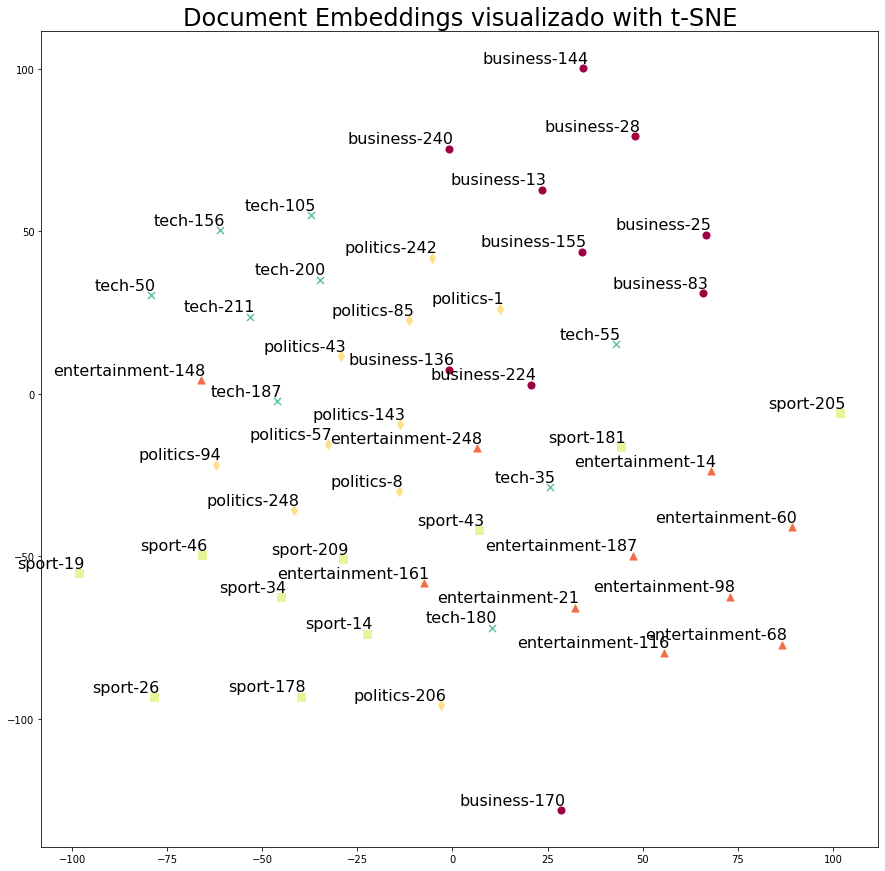

In [22]:
def plot(embeddings, labels):

  # Número de Clusters
  n_clusters = 5

  # Cores para os clusters
  cmap = pylab.cm.get_cmap("Spectral")
  label_colors = [cmap(float(i) /n_clusters) for i in range(n_clusters)]
  label_markers = ['o','^','d','s','x']
  assert embeddings.shape[0] >= len(labels), 'Mais labels que embeddings'

  pylab.figure(figsize=(15,15))  # in inches

  def get_label_id_from_key(key):
    '''
    Nós atribuímos a cada categoria diferente um cluster_id
    Isso é atribuído com base no que está contido no rótulo do ponto
    Não os resultados reais de agrupamento
    '''
    if 'business' in key:
        return 0
    elif 'entertainment' in key:
        return 1
    elif 'politics' in key:
        return 2
    elif 'sport' in key:
        return 3
    elif 'tech' in key:
        return 4

  # Plot
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y, c=label_colors[get_label_id_from_key(label)],s=50,
                  marker=label_markers[get_label_id_from_key(label)])

    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom',fontsize=16)

  pylab.title('Document Embeddings visualizado with t-SNE',fontsize=24)

  # Salva o plot
  pylab.savefig('document_embeddings.png')
  pylab.show()

# Executa
plot(two_d_embeddings, doc_ids)

## Classificando Documentos com o Modelo Treinado

Pudemos inspecionar visualmente os clusters de documentos. No entanto, isso não é suficiente, porque se tivermos mais 1.000 documentos que gostaríamos de agrupar/classificar, teremos que inspecionar visualmente por 1.000 vezes. Então, precisamos de maneiras mais automatizadas para alcançar isso.

Podemos usar o K-means para agrupar esses documentos. K-means é uma técnica simples, mas poderosa, usada para dividir dados em grupos (clusters) com base na similaridade de dados, de modo que dados semelhantes estarão no mesmo grupo e dados diferentes estarão em grupos diferentes. K-means funciona da seguinte maneira: 

- Defina K, o número de clusters a serem formados (em nosso caso 5, já que já sabemos que existem cinco categorias). 
- Formamos K centroids aleatórios, que são os centros dos clusters. 
- Em seguida, atribuiremos cada ponto de dados ao centróide do cluster mais próximo. 
- Depois de atribuir todos os pontos de dados a algum cluster, recompilaremos os centróides do cluster (isto é, média dos pontos de dados). 
- Continuaremos dessa maneira até que o movimento do centróide se torne menor do que um limiar.

Com o resultado do Word2vec, primeiro agrupamos os documentos embeddings por meio do K-means. Em seguida, listaremos o que está contido em cada cluster. Cada cluster deve conter documentos pertencentes a uma única categoria, mas é possível conter documentos de mais de uma categoria por diversas razões. Você pode usar as mesmas informações para classificar seus próprios documentos usando as etapas a seguir.

1. Calcular as embeddings dos documentos para o documento de teste
2. Calcular K-means usando todos os documentos anteriores + o novo documento
3. Rotular o novo documento de teste para ser da categoria à qual a maioria dos vizinhos pertence

In [23]:
# Fit K-means
kmeans = KMeans(n_clusters=5, random_state=43643, max_iter=10000, n_init=100, algorithm='elkan')
kmeans.fit(np.array(list(document_embeddings.values())))

# Computa items que "caem" em cada cluster
document_classes = {}

for inp, lbl in zip(list(document_embeddings.keys()), kmeans.labels_):
    if lbl not in document_classes:
        document_classes[lbl] = [inp]
    else:
        document_classes[lbl].append(inp)

for k,v in document_classes.items():
    print('\nDocumentos no Cluster ',k)
    print('\t',v)


Documentos no Cluster  1
	 ['business-240', 'business-13', 'business-170', 'business-28', 'business-144']

Documentos no Cluster  0
	 ['business-224', 'entertainment-248', 'entertainment-161', 'politics-206', 'politics-94', 'politics-143', 'politics-57', 'politics-8', 'politics-248', 'politics-1', 'sport-209', 'sport-46', 'sport-181', 'sport-34', 'sport-178', 'sport-14', 'tech-187', 'tech-180']

Documentos no Cluster  3
	 ['business-155', 'business-83', 'business-136', 'business-25', 'entertainment-148', 'politics-85', 'politics-43', 'politics-242', 'tech-35', 'tech-50', 'tech-55', 'tech-105', 'tech-156', 'tech-211', 'tech-200']

Documentos no Cluster  4
	 ['entertainment-68', 'entertainment-14', 'entertainment-98', 'entertainment-116', 'entertainment-21', 'entertainment-187', 'entertainment-60', 'sport-19', 'sport-43', 'sport-26']

Documentos no Cluster  2
	 ['sport-205']


# Fim